# Explore Concepts needed for Lighting Controller

In [6]:
%matplotlib inline

import numpy as np
from PIL import Image, ImageDraw, ImageColor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML
from IPython.display import Image as disp_Image
import colorsys

from led_helper import *

In [7]:
# def display_images( images=None, ms=50, loop=10 ):
#      """
#      Animate a list of images by creating a GIF file
#      then displaying the resulting GIF file
#      """

#      # Save options
#      save_opts = { 'fp':'dev_animated_image.png', 'format':'GIF' }

#      # Get the first image and setup for any remaining images
#      try:
#           first_img = images[0]
#           SAVE_MULTI_OPTS = { 'append_images':images[1:], 'save_all':True, 'duration':ms, 'loop':loop }
#           save_opts.update(SAVE_MULTI_OPTS)

#      except TypeError:
#           first_img = images

#      # Save the image to a temp file as a GIF
#      # (but with extention *.png as required by disp_Image (i.e., display.Image))
#      first_img.save(**save_opts)

#      # Display the GIF from the temp file
#      display( disp_Image( filename=save_opts["fp"], format='png') )

# def rgb_to_string( rgb:tuple ) -> str:
#      return f"rgb({rgb[0]},{rgb[1]},{rgb[2]})"

# def hsv_to_rgb_int( h:float=0.0, s:float=0.0, v:float=0.0 ) -> tuple:
#      """
#      Convert HSV to RGB
#      HSV: Values 0.0 to 1.0
#      RGB: Values 0 to 255
#      """
#      return [ int(256*x) for x in colorsys.hsv_to_rgb(h,s,v) ]

In [8]:
class Model():
    """
    Class representing the sides and top of the model and their LEDs
    """
    def __init__(self):

        # Model Configuration
        self.MODEL_INTERIOR_COLOR = 'rgb(128,128,128)'
        self.MODEL_OUTLINE_COLOR = 'rgb(0,0,0)'
        self.MODEL_CONFIG = {
            'Left': {
                'bbox': (0,200, 200,400),
                'leds': { 'rows': 5, 'cols': 6 }
                },

            'Right': {
                'bbox': (400,200, 600,400),
                'leds': { 'rows': 5, 'cols': 6 }
                },

            'Top': {
                'bbox': (200,0, 400,200),
                'leds': { 'rows': 2, 'cols': 3 }
                }
        }

        # Model image
        self.model = None

        # Light Profiles
        # http://planetpixelemporium.com/tutorialpages/light.html
        self.LIGHT_PROFILE = {
            'Candle': { 'temp': 1900, 'rgb': (255, 147, 41) },
            '40W Tungsten': { 'temp': 2600, 'rgb': (255, 197, 143) },
            '100W Tungsten': { 'temp': 2850, 'rgb': (255, 214, 170) },
            'Halogen': { 'temp': 3200, 'rgb': (255, 241, 224) },
            'Carbon Arc': { 'temp': 5200, 'rgb': (255, 250, 244) },
            'High Noon Sun': { 'temp': 5400, 'rgb': (255, 255, 251) },
            'Direct Sunlight': { 'temp': 6000, 'rgb': (255, 255, 255) },
            'Overcast Sky': { 'temp': 7000, 'rgb': (201, 226, 255) },
            'Clear Blue Sky': { 'temp': 20000, 'rgb': (64, 156, 255) },
        }

        # Lighting Scenarios
        self.LIGHT_SCENARIO = {
            'Idle': None,
            'Standard': None,
            'Energy': None,
        }



    def draw_model_sides_top(self):
        """
        Draw the main components of the model: sides, top
        """
        # Create background enclosure for the model
        self.model = Image.new( "RGB", (600,400), color=(10,10,10) )

        # Prepare to draw objects
        model_draw = ImageDraw.Draw(self.model)

        for c in self.MODEL_CONFIG:
            model_draw.rectangle( self.MODEL_CONFIG[c]['bbox'], fill=self.MODEL_INTERIOR_COLOR, outline=self.MODEL_OUTLINE_COLOR )

    def draw_model_leds(self, led_colors:dict=None ):
        """
        Draw LEDs on the model based upon the configurations
        of the model
        @TODO: and the color for each LED
        """

        # Prepare to draw objects
        model_draw = ImageDraw.Draw(self.model)

        # LEDs
        def _draw_led( xy, color='rgb(0,0,0)' ):
            """
            Draw one LED
            """
            LED_RADIUS = 5
            model_draw.ellipse( [ (xy[0]-LED_RADIUS,xy[1]-LED_RADIUS), (xy[0]+LED_RADIUS,xy[1]+LED_RADIUS)], fill=color, outline='rgb(0,0,0)' )

        for c in self.MODEL_CONFIG:

            # Determine the width and height of this component
            bbox = self.MODEL_CONFIG[c]['bbox']
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]

            # How many columns and rows of LEDs need to fit in this space
            n_cols = self.MODEL_CONFIG[c]['leds']['cols']
            n_rows = self.MODEL_CONFIG[c]['leds']['rows']

            # Determine the number of pixels per LED,
            # Adding 2 to the count so that LEDs will not be placed on an edge
            pix_per_col = w // (n_cols + 1)
            pix_per_row = h // (n_rows + 1)
            # print(c, bbox, w, h, n_cols, n_rows, pix_per_col, pix_per_row)

            # Draw the LEDs, starting with index 1 (to avoid an edge)
            for col in range(1,n_cols+1):
                for row in range(1, n_rows+1):

                    # Draw the LED using the specified color
                    if led_colors:
                        _draw_led( ( pix_per_col*col + bbox[0], pix_per_row*row + bbox[1] ), color=led_colors[c][row-1][col-1] )
                    else:
                        _draw_led( ( pix_per_col*col + bbox[0], pix_per_row*row + bbox[1] ) )

    def light_profile( self, source=None, temp=None ):
        """
        Set RGB color values based upon light source or light temperature

        Reference:
        * http://planetpixelemporium.com/tutorialpages/light.html
        """

        if (source is not None) and (temp is None):
            return { source: self.LIGHT_PROFILE[source] }

        if (source is None) and (temp is not None):
            for source in self.LIGHT_PROFILE:
                if temp == self.LIGHT_PROFILE[source]['temp']:
                    return { source: self.LIGHT_PROFILE[source] }

        return self.LIGHT_PROFILE


In [11]:
# Create arrays representing the LED colors
def fill_leds( rgb:tuple ):
    led_cols = {}
    for c in m.MODEL_CONFIG:
        led_cols[c] = np.full( (m.MODEL_CONFIG[c]['leds']['rows'], m.MODEL_CONFIG[c]['leds']['cols']), fill_value=rgb_to_string( rgb ) ) 
        # print( c, (m.MODEL_CONFIG[c]['leds']['rows'], m.MODEL_CONFIG[c]['leds']['cols']), '=>', led_cols[c].shape )

    return led_cols


In [12]:
m2 = Model()
display( m2.light_profile(source='Direct Sunlight') )
display( m2.light_profile(temp=5200) )
display( m2.light_profile() )

{'Direct Sunlight': {'temp': 6000, 'rgb': (255, 255, 255)}}

{'Carbon Arc': {'temp': 5200, 'rgb': (255, 250, 244)}}

{'Candle': {'temp': 1900, 'rgb': (255, 147, 41)},
 '40W Tungsten': {'temp': 2600, 'rgb': (255, 197, 143)},
 '100W Tungsten': {'temp': 2850, 'rgb': (255, 214, 170)},
 'Halogen': {'temp': 3200, 'rgb': (255, 241, 224)},
 'Carbon Arc': {'temp': 5200, 'rgb': (255, 250, 244)},
 'High Noon Sun': {'temp': 5400, 'rgb': (255, 255, 251)},
 'Direct Sunlight': {'temp': 6000, 'rgb': (255, 255, 255)},
 'Overcast Sky': {'temp': 7000, 'rgb': (201, 226, 255)},
 'Clear Blue Sky': {'temp': 20000, 'rgb': (64, 156, 255)}}

Profile: Candle => rgb: (255, 147, 41) => hls: (0.0825545171339564, 0.578125, 0.9907407407407407)
Profile: 40W Tungsten => rgb: (255, 197, 143) => hls: (0.08035714285714285, 0.77734375, 0.9824561403508771)
Profile: 100W Tungsten => rgb: (255, 214, 170) => hls: (0.08627450980392155, 0.830078125, 0.9770114942528736)
Profile: Halogen => rgb: (255, 241, 224) => hls: (0.09139784946236558, 0.935546875, 0.9393939393939394)
Profile: Carbon Arc => rgb: (255, 250, 244) => hls: (0.0909090909090909, 0.974609375, 0.8461538461538461)
Profile: High Noon Sun => rgb: (255, 255, 251) => hls: (0.16666666666666666, 0.98828125, 0.6666666666666666)
Profile: Direct Sunlight => rgb: (255, 255, 255) => hls: (0.0, 0.99609375, 0.0)
Profile: Overcast Sky => rgb: (201, 226, 255) => hls: (0.5895061728395062, 0.890625, 0.9642857142857143)
Profile: Clear Blue Sky => rgb: (64, 156, 255) => hls: (0.5863874345549739, 0.623046875, 0.9896373056994818)


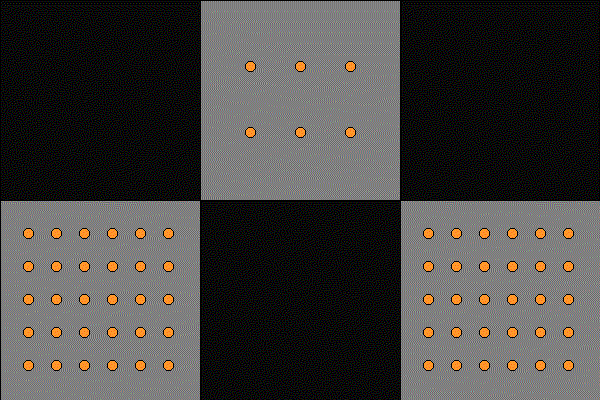

In [17]:
# Create a model
m = Model()

# Draw the sides and top of the model
m.draw_model_sides_top()

images = []
for p in m2.LIGHT_PROFILE:
    rgb = m2.LIGHT_PROFILE[p]['rgb']
    hls = rgb_int_to_hls( rgb )
    hsv = rgb_int_to_hsv( rgb )
    print(f"Profile: {p} => rgb: {rgb} => hls: {hls}")
    # print(f"Profile: {p} => rgb: {rgb} => hsv: {hsv}")
    # print(f"Profile: {p} => rgb: {rgb}")    

    lc = fill_leds( rgb )
    m.draw_model_leds( lc )
    images.append( m.model.copy() )

display_images( images, ms=500, loop=0 )

In [ ]:
# Create a model
m = Model()

# Draw the sides and top of the model
m.draw_model_sides_top()

# Draw LEDs with default color
m.draw_model_leds()

# Display the model
display( m.model )

In [ ]:
# Display a series of colors
images = []
for x in np.arange(0, 2.0, 0.1):
    lc = fill_leds( hsv_to_rgb_int( (0, np.abs(1-x), 0.5 ) ) )
    m.draw_model_leds( lc )
    images.append( m.model.copy() )

display_images( images, ms=1, loop=0 )

In [ ]:
# Display a series of colors
images = []
for x in np.arange(0, 2.0, 0.1):
    lc = fill_leds( hls_to_rgb_int( (0, np.abs(1-x), 0.5) ) )
    m.draw_model_leds( lc )
    images.append( m.model.copy() )

display_images( images, ms=1, loop=0 )

In [ ]:
# Display a series of colors
images = []
for x in np.arange(0, 2.0, 0.1):
    lc = fill_leds( hls_to_rgb_int( (0, np.abs(1-x), 0.5) ) )
    m.draw_model_leds( lc )
    images.append( m.model.copy() )

display_images( images, ms=1, loop=0 )